<a href="https://colab.research.google.com/github/youngmook/aihub/blob/main/drought_Prediction_SPI3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 가뭄 예측 모델

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error

In [43]:
df = pd.read_csv('./train_spi3_136_4717031000.csv')


# EDA: Time Series Analysis

In [32]:
df

,datetime,avgTa,minTa,minTaHrmt,maxTa,maxTaHrmt,maxInsWs,maxInsWsWd,maxInsWsHrmt,maxWs,...,avgPv,avgPa,maxPs,maxPsHrmt,minPsHrmt,avgPs,ssDur,avgTca,avgTs,anlval
0,2013-01-01,-7.0,-13.5,451,-1.2,1421,3.2,140,1239,2.2,...,3.2,1002.3,1023.0,224,1453,1020.4,9.7,6.8,-2.7,0.76
1,2013-01-02,-7.2,-12.5,2350,-3.7,426,13.0,320,1700,6.4,...,1.8,1010.4,1034.0,2355,112,1028.7,9.7,2.0,-1.3,0.75
2,2013-01-03,-11.3,-15.0,2333,-6.8,1446,9.7,270,1236,5.8,...,1.2,1016.5,1037.6,953,1439,1035.2,9.7,0.0,-2.7,0.79
3,2013-01-04,-12.6,-20.4,658,-3.3,1530,3.7,290,1457,2.1,...,1.4,1013.0,1035.8,345,2314,1031.7,9.8,0.3,-6.8,0.80
4,2013-01-05,-8.8,-18.7,737,1.0,1556,6.7,320,1538,4.3,...,2.0,1007.7,1028.9,4,1530,1026.0,9.8,2.5,-6.0,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4043,2024-01-27,-0.5,-7.0,803,6.8,1525,7.2,270,1646,3.9,...,3.4,1009.9,1030.5,805,1618,1027.9,10.2,0.8,0.2,1.45
4044,2024-01-28,-0.7,-5.1,748,4.3,1403,8.6,270,1406,5.4,...,3.4,1011.5,1032.4,2344,320,1029.5,10.3,1.9,0.4,1.46
4045,2024-01-29,-2.1,-8.7,627,5.2,1609,5.5,250,1351,3.0,...,3.3,1014.1,1034.2,812,1503,1032.2,10.3,0.0,-0.3,1.48
4046,2024-01-30,-0.5,-8.2,753,8.2,1605,3.7,290,1433,1.9,...,3.6,1013.0,1034.5,849,2357,1031.0,10.3,1.4,-0.3,1.48


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4048 entries, 0 to 4047
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   datetime      4048 non-null   object 
 1   avgTa         4048 non-null   float64
 2   minTa         4048 non-null   float64
 3   minTaHrmt     4048 non-null   int64  
 4   maxTa         4048 non-null   float64
 5   maxTaHrmt     4048 non-null   int64  
 6   maxInsWs      4048 non-null   float64
 7   maxInsWsWd    4048 non-null   int64  
 8   maxInsWsHrmt  4048 non-null   int64  
 9   maxWs         4048 non-null   float64
 10  maxWsWd       4048 non-null   int64  
 11  maxWsHrmt     4048 non-null   int64  
 12  avgWs         4048 non-null   float64
 13  hr24SumRws    4048 non-null   int64  
 14  maxWd         4048 non-null   int64  
 15  avgTd         4048 non-null   float64
 16  minRhm        4048 non-null   int64  
 17  minRhmHrmt    4048 non-null   int64  
 18  avgRhm        4048 non-null 

In [34]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avgTa,4048.0,12.720627,10.095528,-12.60,3.8000,13.40,21.5000,32.00
minTa,4048.0,7.289921,10.662425,-20.40,-1.9000,7.30,16.8000,26.40
minTaHrmt,4048.0,846.337698,709.032838,1.00,457.7500,604.00,729.0000,2400.00
maxTa,4048.0,18.839995,10.140419,-7.70,10.0000,20.30,27.5000,38.90
maxTaHrmt,4048.0,1409.687747,301.472560,1.00,1403.0000,1456.00,1538.0000,2359.00
maxInsWs,4048.0,7.507312,2.782738,1.50,5.5000,7.20,9.1000,22.70
maxInsWsWd,4048.0,232.524704,81.533058,20.00,140.0000,270.00,290.0000,360.00
maxInsWsHrmt,4048.0,1435.242342,393.441670,1.00,1305.0000,1446.00,1629.0000,2400.00
maxWs,4048.0,4.259264,1.533727,1.10,3.1000,4.20,5.2000,11.30
maxWsWd,4048.0,229.266304,78.681564,20.00,140.0000,270.00,290.0000,360.00


In [35]:
def decompose_bike_sharing_demand(df, share_type='anlval', samples=250, period=24):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)

    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid

    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()

    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()

    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()

    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()

    plt.show()

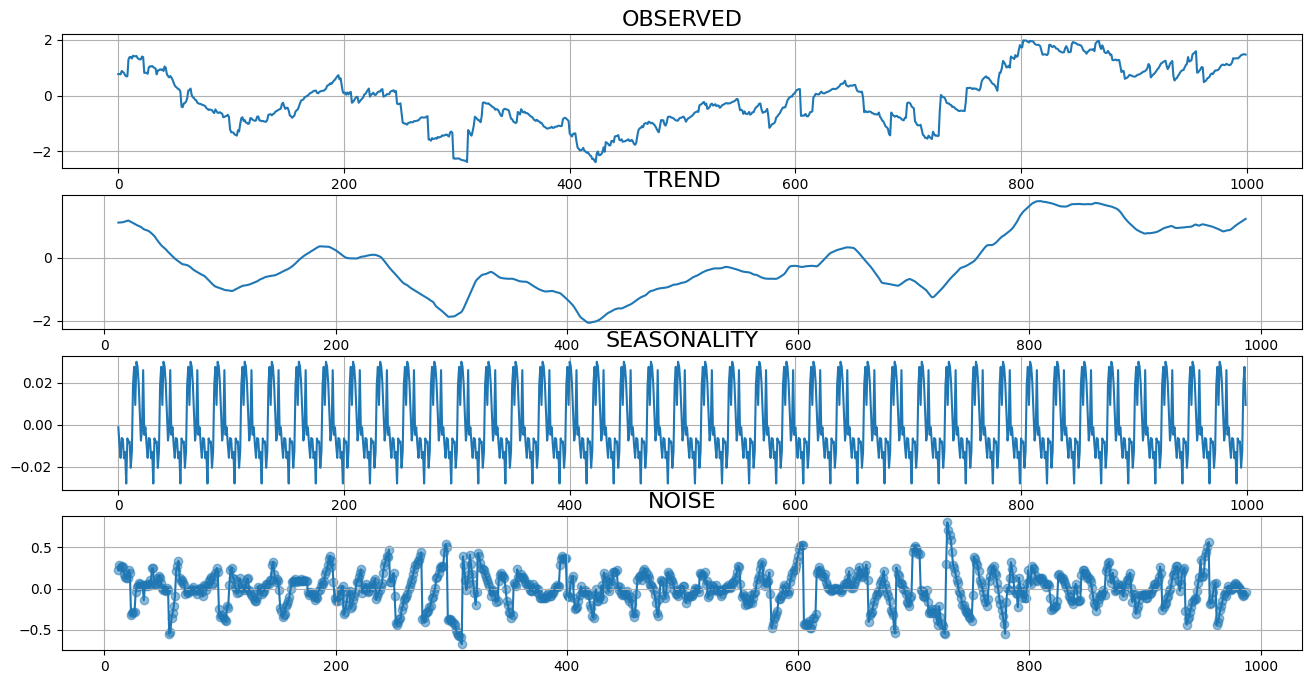

In [36]:
decompose_bike_sharing_demand(df, samples=1000, period=24)

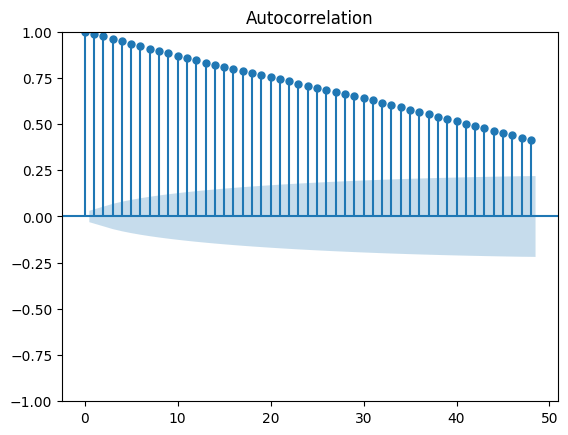

In [37]:
plot_acf(df['anlval'].values, lags=48)
plt.show()

# Time Series Modelling

# Microsoft's Light Gradient Boosting Machine

In [38]:
df

,datetime,avgTa,minTa,minTaHrmt,maxTa,maxTaHrmt,maxInsWs,maxInsWsWd,maxInsWsHrmt,maxWs,...,avgPv,avgPa,maxPs,maxPsHrmt,minPsHrmt,avgPs,ssDur,avgTca,avgTs,anlval
0,2013-01-01,-7.0,-13.5,451,-1.2,1421,3.2,140,1239,2.2,...,3.2,1002.3,1023.0,224,1453,1020.4,9.7,6.8,-2.7,0.76
1,2013-01-02,-7.2,-12.5,2350,-3.7,426,13.0,320,1700,6.4,...,1.8,1010.4,1034.0,2355,112,1028.7,9.7,2.0,-1.3,0.75
2,2013-01-03,-11.3,-15.0,2333,-6.8,1446,9.7,270,1236,5.8,...,1.2,1016.5,1037.6,953,1439,1035.2,9.7,0.0,-2.7,0.79
3,2013-01-04,-12.6,-20.4,658,-3.3,1530,3.7,290,1457,2.1,...,1.4,1013.0,1035.8,345,2314,1031.7,9.8,0.3,-6.8,0.80
4,2013-01-05,-8.8,-18.7,737,1.0,1556,6.7,320,1538,4.3,...,2.0,1007.7,1028.9,4,1530,1026.0,9.8,2.5,-6.0,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4043,2024-01-27,-0.5,-7.0,803,6.8,1525,7.2,270,1646,3.9,...,3.4,1009.9,1030.5,805,1618,1027.9,10.2,0.8,0.2,1.45
4044,2024-01-28,-0.7,-5.1,748,4.3,1403,8.6,270,1406,5.4,...,3.4,1011.5,1032.4,2344,320,1029.5,10.3,1.9,0.4,1.46
4045,2024-01-29,-2.1,-8.7,627,5.2,1609,5.5,250,1351,3.0,...,3.3,1014.1,1034.2,812,1503,1032.2,10.3,0.0,-0.3,1.48
4046,2024-01-30,-0.5,-8.2,753,8.2,1605,3.7,290,1433,1.9,...,3.6,1013.0,1034.5,849,2357,1031.0,10.3,1.4,-0.3,1.48


In [45]:
df

,datetime,avgTa,minTa,minTaHrmt,maxTa,maxTaHrmt,maxInsWs,maxInsWsWd,maxInsWsHrmt,maxWs,...,avgPv,avgPa,maxPs,maxPsHrmt,minPsHrmt,avgPs,ssDur,avgTca,avgTs,anlval
0,2013-01-01,-7.0,-13.5,451,-1.2,1421,3.2,140,1239,2.2,...,3.2,1002.3,1023.0,224,1453,1020.4,9.7,6.8,-2.7,0.76
1,2013-01-02,-7.2,-12.5,2350,-3.7,426,13.0,320,1700,6.4,...,1.8,1010.4,1034.0,2355,112,1028.7,9.7,2.0,-1.3,0.75
2,2013-01-03,-11.3,-15.0,2333,-6.8,1446,9.7,270,1236,5.8,...,1.2,1016.5,1037.6,953,1439,1035.2,9.7,0.0,-2.7,0.79
3,2013-01-04,-12.6,-20.4,658,-3.3,1530,3.7,290,1457,2.1,...,1.4,1013.0,1035.8,345,2314,1031.7,9.8,0.3,-6.8,0.80
4,2013-01-05,-8.8,-18.7,737,1.0,1556,6.7,320,1538,4.3,...,2.0,1007.7,1028.9,4,1530,1026.0,9.8,2.5,-6.0,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4043,2024-01-27,-0.5,-7.0,803,6.8,1525,7.2,270,1646,3.9,...,3.4,1009.9,1030.5,805,1618,1027.9,10.2,0.8,0.2,1.45
4044,2024-01-28,-0.7,-5.1,748,4.3,1403,8.6,270,1406,5.4,...,3.4,1011.5,1032.4,2344,320,1029.5,10.3,1.9,0.4,1.46
4045,2024-01-29,-2.1,-8.7,627,5.2,1609,5.5,250,1351,3.0,...,3.3,1014.1,1034.2,812,1503,1032.2,10.3,0.0,-0.3,1.48
4046,2024-01-30,-0.5,-8.2,753,8.2,1605,3.7,290,1433,1.9,...,3.6,1013.0,1034.5,849,2357,1031.0,10.3,1.4,-0.3,1.48


In [46]:
#convert datetime from object to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])
#set datetime as index
df = df.set_index(df.datetime)


In [47]:
df

,datetime,avgTa,minTa,minTaHrmt,maxTa,maxTaHrmt,maxInsWs,maxInsWsWd,maxInsWsHrmt,maxWs,...,avgPv,avgPa,maxPs,maxPsHrmt,minPsHrmt,avgPs,ssDur,avgTca,avgTs,anlval
datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2013-01-01,-7.0,-13.5,451,-1.2,1421,3.2,140,1239,2.2,...,3.2,1002.3,1023.0,224,1453,1020.4,9.7,6.8,-2.7,0.76
2013-01-02,2013-01-02,-7.2,-12.5,2350,-3.7,426,13.0,320,1700,6.4,...,1.8,1010.4,1034.0,2355,112,1028.7,9.7,2.0,-1.3,0.75
2013-01-03,2013-01-03,-11.3,-15.0,2333,-6.8,1446,9.7,270,1236,5.8,...,1.2,1016.5,1037.6,953,1439,1035.2,9.7,0.0,-2.7,0.79
2013-01-04,2013-01-04,-12.6,-20.4,658,-3.3,1530,3.7,290,1457,2.1,...,1.4,1013.0,1035.8,345,2314,1031.7,9.8,0.3,-6.8,0.80
2013-01-05,2013-01-05,-8.8,-18.7,737,1.0,1556,6.7,320,1538,4.3,...,2.0,1007.7,1028.9,4,1530,1026.0,9.8,2.5,-6.0,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-27,2024-01-27,-0.5,-7.0,803,6.8,1525,7.2,270,1646,3.9,...,3.4,1009.9,1030.5,805,1618,1027.9,10.2,0.8,0.2,1.45
2024-01-28,2024-01-28,-0.7,-5.1,748,4.3,1403,8.6,270,1406,5.4,...,3.4,1011.5,1032.4,2344,320,1029.5,10.3,1.9,0.4,1.46
2024-01-29,2024-01-29,-2.1,-8.7,627,5.2,1609,5.5,250,1351,3.0,...,3.3,1014.1,1034.2,812,1503,1032.2,10.3,0.0,-0.3,1.48


In [48]:

#drop datetime column
df.drop('datetime', axis=1, inplace=True)

In [49]:
#create hour, day and month variables from datetime index
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month

#drop casual and registered columns
#df.drop(['casual', 'registered'], axis=1, inplace=True)

In [50]:
df

,avgTa,minTa,minTaHrmt,maxTa,maxTaHrmt,maxInsWs,maxInsWsWd,maxInsWsHrmt,maxWs,maxWsWd,...,maxPsHrmt,minPsHrmt,avgPs,ssDur,avgTca,avgTs,anlval,hour,day,month
datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-01,-7.0,-13.5,451,-1.2,1421,3.2,140,1239,2.2,140,...,224,1453,1020.4,9.7,6.8,-2.7,0.76,0,1,1
2013-01-02,-7.2,-12.5,2350,-3.7,426,13.0,320,1700,6.4,290,...,2355,112,1028.7,9.7,2.0,-1.3,0.75,0,2,1
2013-01-03,-11.3,-15.0,2333,-6.8,1446,9.7,270,1236,5.8,270,...,953,1439,1035.2,9.7,0.0,-2.7,0.79,0,3,1
2013-01-04,-12.6,-20.4,658,-3.3,1530,3.7,290,1457,2.1,290,...,345,2314,1031.7,9.8,0.3,-6.8,0.80,0,4,1
2013-01-05,-8.8,-18.7,737,1.0,1556,6.7,320,1538,4.3,290,...,4,1530,1026.0,9.8,2.5,-6.0,0.80,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-27,-0.5,-7.0,803,6.8,1525,7.2,270,1646,3.9,250,...,805,1618,1027.9,10.2,0.8,0.2,1.45,0,27,1
2024-01-28,-0.7,-5.1,748,4.3,1403,8.6,270,1406,5.4,270,...,2344,320,1029.5,10.3,1.9,0.4,1.46,0,28,1
2024-01-29,-2.1,-8.7,627,5.2,1609,5.5,250,1351,3.0,270,...,812,1503,1032.2,10.3,0.0,-0.3,1.48,0,29,1


In [100]:
def train_time_series_with_folds(df, horizon=24*7*11):
    X = df.drop('anlval', axis=1)
    y = df['anlval']

    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

    #create, train and do inference of the model
    model = LGBMRegressor(random_state=100)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)

    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('SPI3', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()

    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()

# Train Model without Lags

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5302
[LightGBM] [Info] Number of data points in the train set: 1360, number of used features: 30
[LightGBM] [Info] Start training from score -0.092551


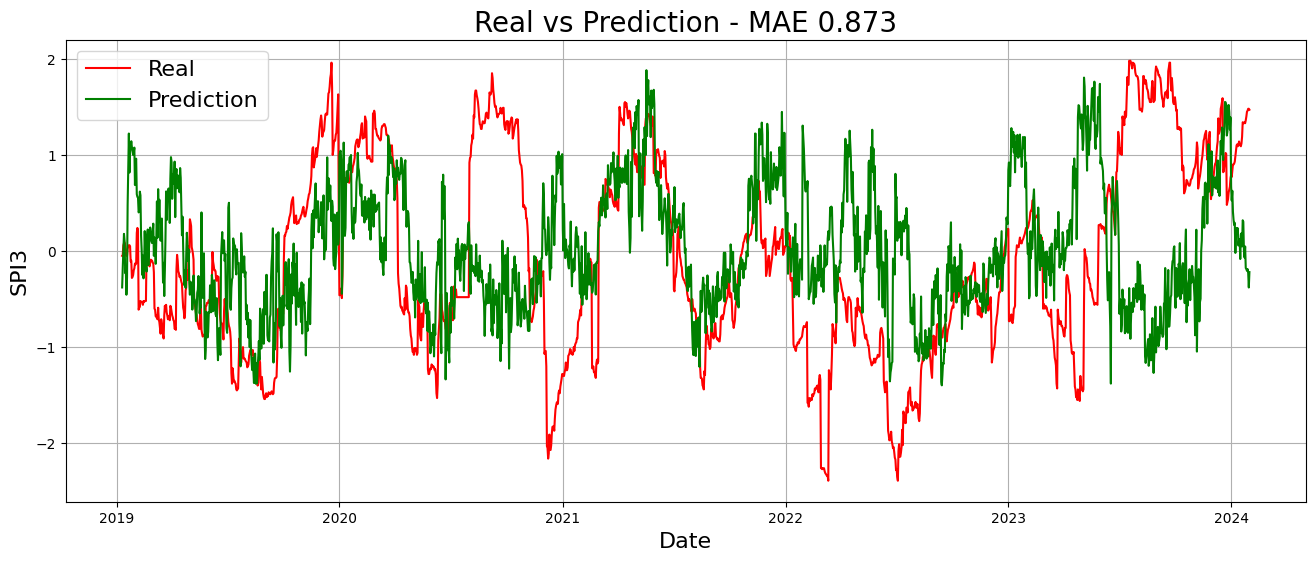

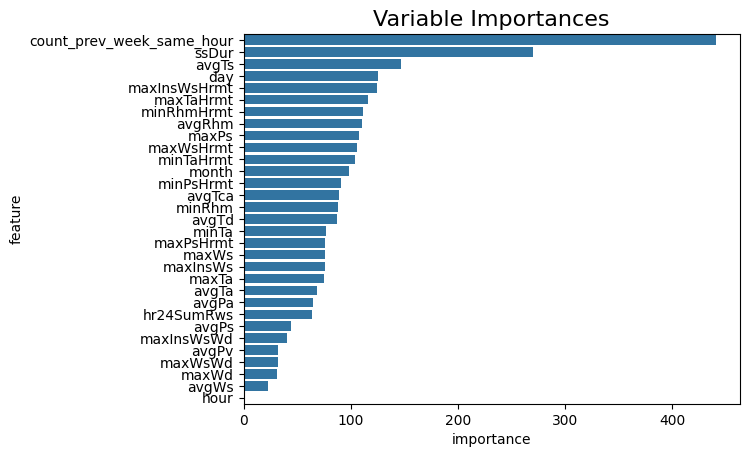

In [101]:
train_time_series_with_folds(df)

# Train Model with Lags

In [102]:
#create 1 week lag variable by shifting the target value for 1 week
df['count_prev_week_same_hour'] = df['anlval'].shift(24*7)

#drop NaNs after feature engineering
df.dropna(how='any', axis=0, inplace=True)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5300
[LightGBM] [Info] Number of data points in the train set: 1192, number of used features: 30
[LightGBM] [Info] Start training from score 0.036485


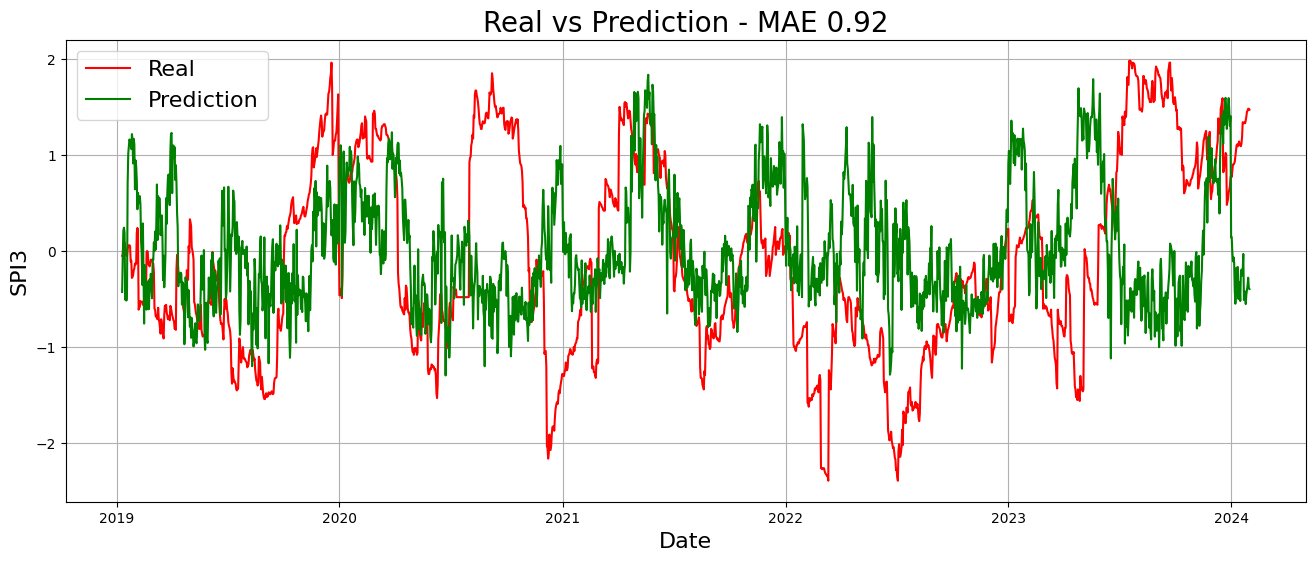

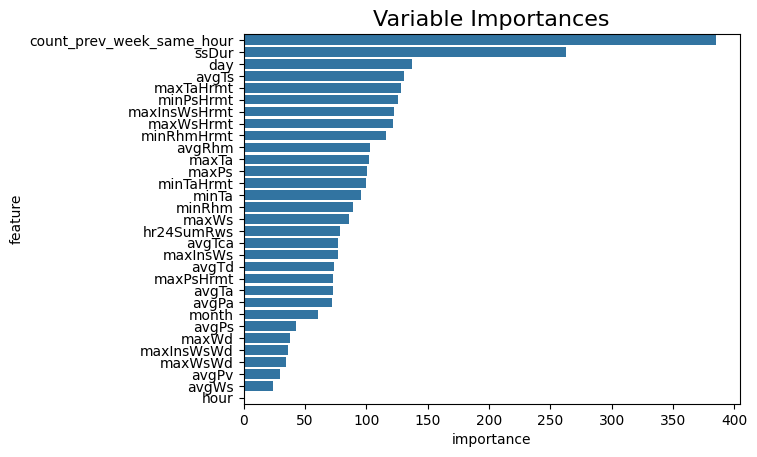

In [103]:
train_time_series_with_folds(df)